# Introduction to PyTorch part 2

## Class-based Dataset Definition

In [1]:
from torch.utils.data import Dataset
import pandas as pd


class WaterDataset(Dataset):
    def __init__(self, csv_path: str):
        super().__init__()
        df = pd.read_csv(csv_path)
        self.data = df.to_numpy()

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx: int):
        features = self.data[idx, :-1]
        label = self.data[idx, -1]
        return features, label

In [2]:
from torch.utils.data import DataLoader

dataset_train = WaterDataset("./data/water_dataset.csv")
dataloader_train = DataLoader(dataset_train, batch_size=2, shuffle=True)

In [3]:
features, labels = next(iter(dataloader_train))
print(f"Features: {features}")
print(f"Labels: {labels}")

Features: tensor([[0.4721, 0.6917, 0.3143, 0.7173, 0.5489, 0.4336, 0.4584, 0.4644, 0.5062],
        [0.5272, 0.4259, 0.4356, 0.6154, 0.6824, 0.3376, 0.4817, 0.3499, 0.4012]],
       dtype=torch.float64)
Labels: tensor([0., 0.], dtype=torch.float64)


## Class-based Model Definition

### From this:

In [4]:
from torch import nn


net = nn.Sequential(
    nn.Linear(9, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid(),
)

### To this:

In [5]:
from torch import nn


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(9, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x))
        return x


net = Net()

### Weight Initialization

In [6]:
from torch import nn


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(9, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

        # Apply He/Kaiming initialization
        nn.init.kaiming_uniform_(self.fc1.weight)
        nn.init.kaiming_uniform_(self.fc2.weight)
        nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity="sigmoid")

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x))
        return x


net = Net()

### Batch Normalization

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(9, 16)
        # Add two batch normalization layers
        self.bn1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(16, 8)
        self.bn2 = nn.BatchNorm1d(8)
        self.fc3 = nn.Linear(8, 1)

        # Apply He/Kaiming initialization
        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        init.kaiming_uniform_(self.fc3.weight, nonlinearity="sigmoid")

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)

        # Pass x through the second set of layers
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)

        x = nn.functional.sigmoid(self.fc3(x))
        return x

## Taining Loop

In [8]:
from torch import nn, optim

criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

for epoch in range(10):  # iterate over epochs and training batches
    for features, labels in dataloader_train:
        features = features.float()  # convert features to float32
        labels = labels.float()  # convert labels to float32
        optimizer.zero_grad()  # clear gradients
        outputs = net(features)  # forward pass and get model's output
        loss = criterion(outputs, labels.view(-1, 1))  # compute loss
        loss.backward()  # compute gradients
        optimizer.step()  # update params

### Some options for optimizer

In [9]:
optimizer = optim.SGD(net.parameters(), lr=0.01)  # Stochastic Gradient Descent
optimizer = optim.Adagrad(net.parameters(), lr=0.01)  # Adaptive Gradient
optimizer = optim.RMSprop(net.parameters(), lr=0.01)  # Root Mean Square Propagation
optimizer = optim.Adam(net.parameters(), lr=0.01)  # Adaptive Moment Estimation

### Model Evaluation

In [10]:
import torch
from torchmetrics import Accuracy

acc = Accuracy(task="binary")  # setup accuracy metric


net.eval()  # set model to evaluation mode
with torch.no_grad():  # iterate over test data batches with no gradients
    # for features, labels in dataloader_test:
    for features, labels in dataloader_train:
        features = features.float()  # convert features to float32
        labels = labels.float()  # convert labels to float32
        outputs = net(features)  # pass data to model
        preds = (
            outputs >= 0.5
        ).float()  # compute predicted labels (based on 0.5 treshold)
        acc(preds, labels.view(-1, 1))  # update accuracy metric

accuracy = acc.compute()
print(f"Accuracy: {accuracy}")

Accuracy: 0.6100795865058899


## Image Dataset

Data Source: https://www.kaggle.com/competitions/cloud-type-classification2/data

### Define Image Transformation

In [11]:
from torchvision import transforms


train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),  # parse to tensor
        transforms.Resize((128, 128)),  # resize to 128x128
    ]
)

### Prepare DataLoader

In [12]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


dataset_train = ImageFolder("./data/cloud_dataset", transform=train_transforms)

dataloader_train = DataLoader(dataset_train, shuffle=True, batch_size=1)

In [13]:
image, label = next(iter(dataloader_train))
print(image.shape)  # batch size, color channel in RGB, x-axis, y-axis

torch.Size([1, 3, 128, 128])


### Display the Image

In [14]:
image = image.squeeze().permute(1, 2, 0)
print(image.shape)

torch.Size([128, 128, 3])


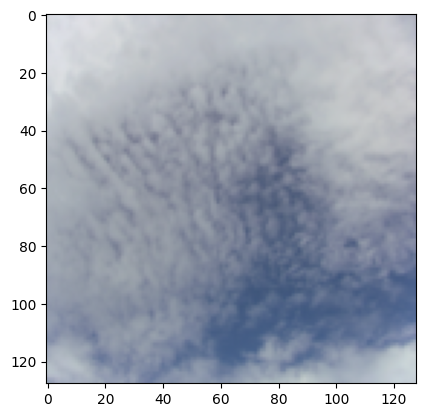

In [15]:
import matplotlib.pyplot as plt

plt.imshow(image)
plt.show()

### Data Augmentation

Generating more data by applying random transformations to original images. <br/>
Objectives:
- Increase the size and diversity of the training set
- Improve model robustness
- Reduce overfitting

In [16]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


train_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
        transforms.ToTensor(),  # parse to tensor
        transforms.Resize((64, 64)),  # resize to 64x64
    ]
)


dataset_train = ImageFolder("./data/cloud_dataset", transform=train_transforms)

dataloader_train = DataLoader(dataset_train, shuffle=True, batch_size=1)

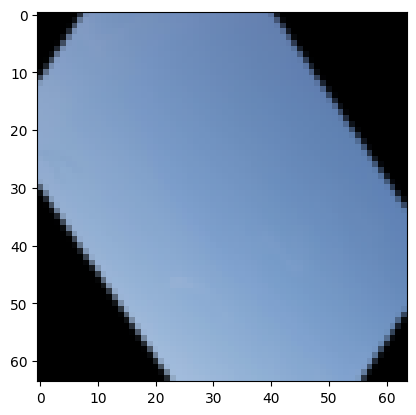

In [17]:
import matplotlib.pyplot as plt


image, label = next(iter(dataloader_train))
image = image.squeeze().permute(1, 2, 0)
plt.imshow(image)
plt.show()

## Convolutional Neural Networks (CNN)

In [18]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # feature extractor: [convolution, activation, pooling] -> repeated twice and flattened
        self.feature_extractor = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),  # 128x128 -> 64x64
            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),  # 64x64 -> 32x32
            # Flattened
            nn.Flatten(),
        )

        self.classifier = nn.Linear(64 * 16 * 16, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

## Training CNN

### Dataset & Augmentation

In [19]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


train_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
        transforms.RandomAutocontrast(),
        transforms.ToTensor(),  # parse to tensor
        transforms.Resize((64, 64)),  # resize to 64x64
    ]
)


dataset_train = ImageFolder("./data/cloud_dataset", transform=train_transforms)

dataloader_train = DataLoader(dataset_train, shuffle=True, batch_size=1)

### Loss Function

- Binary Classification: Binary Cross Entropy (BCE) loss function
- Multi-class Classification: Cross Entropy loss function

In [20]:
from torch import nn

criterion = nn.CrossEntropyLoss()

### Training Loop

In [21]:
from torch import nn, optim

net = Net(num_classes=7)
criterion = (
    nn.CrossEntropyLoss()
)  # Cross Entropy loss function for multi-class classification
optimizer = optim.Adam(net.parameters(), lr=0.001)


def run_training_loop():
    for epoch in range(2):
        for images, labels in dataloader_train:
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


# run_training_loop()

## Electricity Dataset

Data Source: https://archive.ics.uci.edu/dataset/321/electricityloaddiagrams20112014

In [22]:
import pandas as pd


train_data = pd.read_csv(
    "./data/electricity_dataset/LD2011_2014.txt", delimiter=";", skiprows=1
)
train_data.head()

/var/folders/0l/pr3b5n8n57scvxnhx_zl7yfw0000gp/T/ipykernel_47168/313986538.py:4: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,125,126,127,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,157,160,164,165,167,170,173,177,178,179,181,184,185,186,223,224,255,280,289,305,308,322,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,363,364,365,366,367,368,369,370) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv(


,2011-01-01 00:15:00,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.202,0.203,0.204,0.205,0.206,0.207,0.208,0.209,0.210,0.211
0,2011-01-01 00:30:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
1,2011-01-01 00:45:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2,2011-01-01 01:00:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
3,2011-01-01 01:15:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
4,2011-01-01 01:30:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0


In [23]:
# train_data = train_data.iloc[:, [0, -1]]
# train_data.head()

In [24]:
import numpy as numpy
import pandas as pd


def create_sequences(df: pd.DataFrame, seq_length: int):
    xs, ys = [], []
    for i in range(len(df) - seq_length):
        x = df.iloc[i : (i + seq_length), 1]
        y = df.iloc[i + seq_length, 1]
        xs.append(x)
        ys.append(y)

In [25]:
# seq_length = 24 * 4
# X_train, y_train = create_sequences(train_data, seq_length)
# print(X_train.shape, y_train.shape)

In [26]:
# import torch
# from torch.utils.data import TensorDataset

# dataset_train = TensorDataset(
#     torch.from_numpy(X_train.float()),
#     torch.from_numpy(y_train.float())
# )

## Sequence to Vector Recurrent Neural Networks (RNN)

In [27]:
import torch
from torch import nn


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
        )
        sf.fc = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 32)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out